# Senzing + Neo4j: Analyze impact of ERKG

## Set up the Python environment

First, we need to import the Python library dependencies which are required for the code we'll be running.

In [1]:
import os

from graphdatascience import GraphDataScience 
from icecream import ic
from tqdm import tqdm
import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import pyvis
import seaborn as sns
import watermark

%load_ext watermark

Show a "watermark" of which versions are being used for system componenents and library dependencies. This may help in case you need to troubleshoot the dependencies on your system, e.g., if there's some conflict during installation.

In [2]:
%watermark
%watermark --iversions

Last updated: 2024-03-31T16:10:02.761976-07:00

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.22.2

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
pandas    : 2.2.1
matplotlib: 3.8.3
watermark : 2.4.3
pyvis     : 0.3.2



Let's define a `dataclass` to represent the parsed results from Senzing entity resolution.

In [4]:
@dataclass(order=False, frozen=False)
class Entity:  # pylint: disable=R0902
    """
A data class representing a resolved entity.
    """
    entity_id: id
    num_recs: int
    records: typing.Set[ str ] = field(default_factory = lambda: set([]))
    related: typing.Dict[ int, dict ] = field(default_factory = lambda: {})
    has_ref: bool = False

Parse the JSON data from the export, to build a dictionary of entities indexed by their unique identifiers. Also keep track of both the "resolved" and "related" records for each entity, to use for constructing the knowledge graph from these results.

In [6]:
export_path: pathlib.Path = pathlib.Path("../export.json")
entities: dict = {}

with export_path.open() as fp:
    for line in tqdm(fp.readlines(), desc = "read JSON"):
        entity_dat: dict = json.loads(line)
        entity_id: int = entity_dat["RESOLVED_ENTITY"]["ENTITY_ID"]

        records: set = set([
            ".".join([ r["DATA_SOURCE"].upper(), str(r["RECORD_ID"]) ])
            for r in entity_dat["RESOLVED_ENTITY"]["RECORDS"]
        ])

        entities[entity_id] = Entity(
            entity_id = entity_id,
            records = records,
            num_recs = len(records),
            related = {
                r["ENTITY_ID"]: r
                for r in entity_dat["RELATED_ENTITIES"]
            },
        )

read JSON: 100%|████████████████████████████████████████████████████████████████████████████████████| 99156/99156 [00:02<00:00, 33793.16it/s]


To finish preparing the input data for resolved entities, let's make a quick traversal of the record linkage and set a flag for "interesting" entities which will have relations in the graph to visualize.

In [7]:
for entity in entities.values():
    if entity.num_recs > 0:
        entity.has_ref = True

    for rel_ent_id in entity.related:
        entities[rel_ent_id].has_ref = True

Let's examine one of the resolved entity objects, to see which fields are available

In [8]:
entity_dat

{'RESOLVED_ENTITY': {'ENTITY_ID': 438737,
  'RECORDS': [{'DATA_SOURCE': 'SAFEGRAPH',
    'RECORD_ID': 'zzw-222@5yv-c8t-t7q',
    'ENTITY_TYPE': 'GENERIC',
    'INTERNAL_ID': 438737,
    'ENTITY_KEY': '7A2952039A2EDAE86C89FF025284618BB47F5B0E',
    'ENTITY_DESC': 'Royalty Renee Salez',
    'MATCH_KEY': '',
    'MATCH_LEVEL': 0,
    'MATCH_LEVEL_CODE': '',
    'ERRULE_CODE': '',
    'LAST_SEEN_DT': '2024-03-12 18:54:15.638'}]},
 'RELATED_ENTITIES': []}

In [9]:
ic(list(entities.values())[-1]);

ic| list(entities.values())[-1]: Entity(entity_id=438737,
                                        num_recs=1,
                                        records={'SAFEGRAPH.zzw-222@5yv-c8t-t7q'},
                                        related={},
                                        has_ref=True)


## Connect the GDS library to Neo4j Desktop

Set up a GDS connection using our credentials for Neo4j Desktop

In [2]:
dotenv.load_dotenv(dotenv.find_dotenv())

bolt_uri: str = os.environ.get("NEO4J_BOLT")
database: str = os.environ.get("NEO4J_DBMS")
username: str = os.environ.get("NEO4J_USER")
password: str = os.environ.get("NEO4J_PASS")

gds:GraphDataScience = GraphDataScience(
    bolt_uri,
    auth = ( username, password, ),
    database = database,
    aura_ds = False,
)

### Populate nodes from the Senzing entities

In [19]:
for entity in tqdm(entities.values(), desc = "merge entity nodes"):
    params = {
        "uid": entity.entity_id,
        "has_ref": entity.has_ref,
    }

    gds.run_cypher(
        "MERGE (ent:Entity {uid: $uid, has_ref: $has_ref})",
        params,
    )

merge entity nodes: 100%|██████████████████████████████████████████████████████████████████████████████| 99156/99156 [51:19<00:00, 32.19it/s]


### Connect the resolved records and related entities

In [20]:
query = """
MATCH
    (ent:Entity {uid: $entity_uid}),
    (rec:Record {uid: $record_uid})       
MERGE (ent)-[:RESOLVES]->(rec)
"""

for entity in tqdm(entities.values(), desc = "merge ent->rec"):
    for record_uid in entity.records:
        params = {
            "entity_uid": entity.entity_id,
            "record_uid": record_uid,
        }

        gds.run_cypher(query, params)

merge ent->rec: 100%|██████████████████████████████████████████████████████████████████████████████████| 99156/99156 [46:31<00:00, 35.52it/s]


In [22]:
query = """
MATCH
    (ent:Entity {uid: $entity_uid}),
    (rel_ent:Entity {uid: $rel_ent})       
MERGE (ent)-[:RELATED {ambiguous: $ambiguous, disclosed: $disclosed, match_key: $match_key, match_level: $match_level, match_level_code: $match_level_code}]->(rel_ent)
"""

for entity in tqdm(entities.values(), desc = "merge ent->rel"):
    for rel_key, rel_ent in entity.related.items():
        params = {
            "entity_uid": entity.entity_id,
            "rel_ent": rel_ent["ENTITY_ID"],
            "ambiguous": (rel_ent["IS_AMBIGUOUS"] == 0),
            "disclosed": (rel_ent["IS_DISCLOSED"] == 0),
            "match_key": rel_ent["MATCH_KEY"],
            "match_level": rel_ent["MATCH_LEVEL"],
            "match_level_code": rel_ent["MATCH_LEVEL_CODE"],
        }

        gds.run_cypher(query, params)

merge ent->rel: 100%|████████████████████████████████████████████████████████████████████████████████| 99156/99156 [2:12:30<00:00, 12.47it/s]


In [24]:
query = """
MATCH (ent:Entity)
RETURN COUNT(ent.uid)
    """
    
gds.run_cypher(query, params)

,COUNT(ent.uid)
0,99156


## Analyze the impact of ER

Now let's analyze the Senzing results, measuring how much the process of _entity resolution_ has consolidated records among the input datasets.
In particular, it's helpful to understand:

  - total number of entities
  - number of entities with linked reference (should be 100% in the graph)
  - number of linked records per entity
  - number of related entities per entity

In [50]:
df_ent: pd.DataFrame = gds.run_cypher(
  """
MATCH (ent:Entity)
RETURN ent.uid AS ent_uid, COUNT { (ent)-[:RESOLVES]->(:Record) } AS num_rec, COUNT { (ent)-[:RELATED]->(:Entity) } AS num_rel
ORDER BY num_rec DESC
  """
)

df_rec: pd.DataFrame = gds.run_cypher(
  """
MATCH (ent:Entity)
RETURN COUNT(ent.uid) AS count_ent, COUNT { (ent)-[:RESOLVES]->(:Record) } AS num_rec
ORDER BY num_rec DESC
  """
)

df_rel: pd.DataFrame = gds.run_cypher(
  """
MATCH (ent:Entity)
RETURN COUNT(ent.uid) AS count_ent, COUNT { (ent)-[:RELATED]->(:Entity) } AS num_rel
ORDER BY num_rel DESC
  """
)

In [51]:
total_entities: int = df_ent.ent_uid.count()
total_records: int = df_ent.num_rec.sum()
unref_ents: int = df_rec.loc[df_rec["num_rec"] < 1].count().iloc[0]
dupl_rate: float = round((total_records - total_entities) / float(total_entities), 2)

ic(total_entities, total_records, unref_ents, dupl_rate);

ic| total_entities: 99156
    total_records: 103827
    unref_ents: 0
    dupl_rate: 0.05


Great, 100% of the input records have been resolved as entities – as expected.
A rate of ~5% duplicates was detected among these records.

Now let's run more detailed statistical analysis, visualizing a histogram of the resolved entities versus their related records from the input datasets.

In [52]:
rel_mean: float = df_ent.num_rel.mean()
ic(rel_mean);

ic| rel_mean: 2.566501270724918


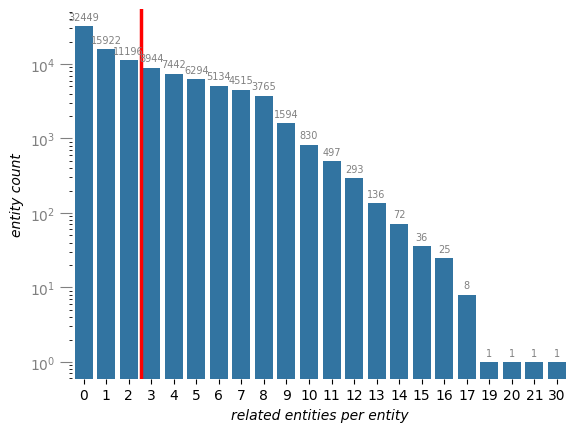

In [53]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"

y = sns.barplot(df_rel, y = "count_ent", x = "num_rel")
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("related entities per entity", size = 10, fontstyle = "italic")
plt.ylabel("entity count", size = 10, fontstyle = "italic")

plt.axvline(x = rel_mean, color = "red", lw = 2.5)

sns.despine(bottom = True, left = True)
plt.yscale("log")

fig.savefig("../article/img/graphs.plot.ent_rel.png")

In [46]:
rec_mean: float = df_ent.num_rec.mean()
ic(rec_mean);

ic| rec_mean: 1.0471075880430836


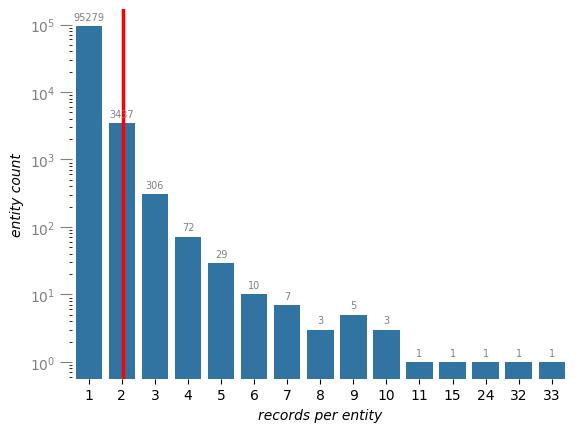

In [55]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"

y = sns.barplot(df_rec, y = "count_ent", x = "num_rec")
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("records per entity", size = 10, fontstyle = "italic")
plt.ylabel("entity count", size = 10, fontstyle = "italic")

plt.axvline(x = rec_mean, color = "red", lw = 2.5)

sns.despine(bottom = True, left = True)
plt.yscale("log")

fig.savefig("../article/img/graphs.plot.ent_rec.png")

## Graph visualizations

In [12]:
df_link = gds.run_cypher(
  """
MATCH (ent:Entity)-[:RESOLVES]->(rec:Record)
RETURN ent.uid AS ent_uid, rec.uid AS rec_uid, COUNT { (ent)-[:RESOLVES]->(:Record) } as num_rec
  """
)

df_link = df_link.loc[df_link["num_rec"] > 1]

In [12]:
net: pyvis.network.Network = pyvis.network.Network(notebook = True)

for _, row in df_link.iterrows():
    net.add_node(row.rec_uid, title = row.rec_uid, color = "blue", shape = "square")

net.toggle_physics(True)
net.show("vegas.1.html")

vegas.1.html


In [13]:
net: pyvis.network.Network = pyvis.network.Network(notebook = True)

for _, row in df_link.iterrows():
    net.add_node(row.rec_uid, title = row.rec_uid, color = "blue", shape = "square")
    net.add_node(row.ent_uid, title = str(row.ent_uid), color = "red", shape = "star", size = row.num_rec)
    net.add_edge(row.rec_uid, row.ent_uid, weight = 1.0)

net.toggle_physics(True)
net.show("vegas.2.html")

vegas.2.html


## Experiments to add more KG structure

In [15]:
df = gds.run_cypher(
  """
MATCH (rec:Record)
WHERE (rec.sub_category) IS NOT NULL 
RETURN DISTINCT rec.sub_category AS sub_category
  """
)

df.dropna(inplace = True)
df

,sub_category
0,Offices of Lawyers
1,Limited-Service Restaurants
2,Offices of All Other Miscellaneous Health Prac...
3,Religious Organizations
4,"Offices of Physicians, Mental Health Specialists"
...,...
13287,Commuter Rail Systems
13520,Newspaper Publishers
14734,Investigation Services
14811,Motor Vehicle Supplies and New Parts Merchant ...


In [16]:
for _, row in df.iterrows():
    gds.run_cypher(
        "MERGE (cat:Category {name: $name })",
        params = { "name": row.sub_category },
    )